In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import visdom

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchsummary import summary

import h5py
%matplotlib notebook 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

In [4]:
device

device(type='cuda')

python -m visdom.server

In [5]:
class VisdomLinePlotter(object):
    """Plots to Visdom"""
    def __init__(self, env_name='main'):
        self.viz = visdom.Visdom()
        self.env = env_name
        self.plots = {}
    def plot(self, var_name, split_name, title_name, x, y, xlabel = 'Epochs'):
        if var_name not in self.plots:
            self.plots[var_name] = self.viz.line(X=np.array([x,x]), Y=np.array([y,y]), env=self.env, opts=dict(
                legend=[split_name],
                title=title_name,
                xlabel=xlabel,
                ylabel=var_name
            ))
        else:
            self.viz.line(X=np.array([x]), Y=np.array([y]), env=self.env, win=self.plots[var_name], name=split_name, update = 'append')
    
    def ImgPlot(self, img, title, caption):
        self.viz.images(
            img,
            opts=dict(title=title, caption=caption
                 
        ))
        
    def VoxelPlot(self, voxels, title):
        dataIO.plotVoxelVisdom(voxels, self.viz, title)

In [6]:
global plotter
plotter = VisdomLinePlotter()

## Dataset loader

In [7]:
path_h5 = '/home/ankbzpx/datasets/ShapeNet/ShapeNetRenderingh5_v1/03001627/'
MODEL_PATH = '/home/ankbzpx/Documents/'

In [8]:
# plot vox or img
from vis_utils import plotFromVoxels, plotImg, plot_image_list

In [9]:
class ChairDepthDataset(Dataset):
    
    def __init__(self, h5_file):
        
        self.hf = h5py.File(h5_file, 'r')
        self.keys = list(self.hf.keys())
        
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        
        group = self.hf[self.keys[idx]]
        
        model_id = str(group['model_id'])
        depth_img = self.to_tensor(Image.fromarray(np.array(group['depth_img'])))
        azimuth = float(group['azimuth'][()])
        elevation = float(group['elevation'][()])
        distance = float(group['distance'][()])
        target_vox = torch.tensor(group['target_vox'], dtype=torch.float)
        #trimap = torch.tensor(group['trimap'], dtype=torch.int)
        
        sample = {'model_id': model_id,
                  'depth_img': depth_img,
                  'azimuth': azimuth,
                  'elevation': elevation,
                  'distance': distance,
                  'target_vox': target_vox, 
                 }

        return sample

In [10]:
train_depth_dataset = ChairDepthDataset(path_h5 + 'data_train_rescale.h5')

batch_size = 128

train_model_dataloader = DataLoader(train_depth_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=12)

In [11]:
len(train_model_dataloader)

988

In [12]:
from models import Discrete_encoder, Mapping, Discrete_decoder

discrete_encoder = Discrete_encoder().to(device)
mapping = Mapping().to(device)
discrete_decoder = Discrete_decoder().to(device)

In [13]:
num_epochs = 30
start_epoch = 0
lr = 1e-4

bceloss = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam([
        {"params": discrete_encoder.parameters(), "lr":lr},
        {"params": mapping.parameters(), "lr":lr},
        {"params": discrete_decoder.parameters(), "lr":lr},
    ])

In [14]:
# Training Loop
batch_len = len(train_model_dataloader)

print("Starting Training Loop...")

for epoch in range(start_epoch, num_epochs):
    
    loss_list = []
    
    print("Epoch: ", epoch)
    
    count = 0
    
    for i, data in enumerate(train_model_dataloader):
        
        # Input image
        depth_img = data['depth_img'].to(device)
        target_vox = data['target_vox'].to(device)
        
        optimizer.zero_grad()
        
        out_vox = discrete_decoder(mapping(discrete_encoder(depth_img)))
        loss = bceloss(out_vox, target_vox)
        loss.backward()
        
        loss_list.append(loss.item())
        
        optimizer.step()
        
        count += 1
        
        plotter.plot('loss', 'BCE', 'Batch Loss', batch_len * epoch + i, loss.item(), 'batch')
        
        if count % 1000 == 0:
            torch.save(discrete_encoder.state_dict(), 'discrete_encoder.pth')
            torch.save(mapping.state_dict(), 'mapping.pth')
            torch.save(discrete_decoder.state_dict(), 'discrete_decoder.pth')
            
    plotter.plot('Average', 'Vox', 'Epoch loss', epoch, np.average(loss_list))
    
    torch.save(discrete_encoder.state_dict(), 'discrete_encoder.pth')
    torch.save(mapping.state_dict(), 'mapping.pth')
    torch.save(discrete_decoder.state_dict(), 'discrete_decoder.pth')
    
print("Training finished")

Starting Training Loop...
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Training finished


## Discrete model evaluation

In [ ]:
test_depth_dataset = ChairDepthDataset(path_h5 + 'data_test_rescale.h5')

batch_size = 128

test_model_dataloader = DataLoader(test_depth_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=12)

<Figure size 432x432 with 0 Axes>

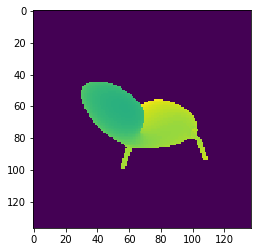

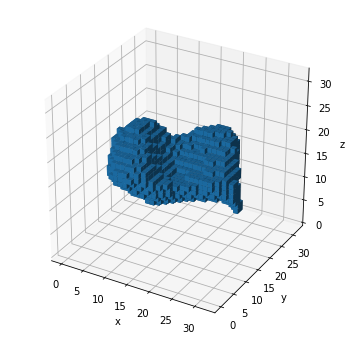

In [22]:
discrete_encoder = Discrete_encoder().to(device)
discrete_encoder.load_state_dict(torch.load(MODEL_PATH + 'discrete continuous shape/discrete_encoder.pth'))
e = discrete_encoder.eval()

discrete_decoder = Discrete_decoder().to(device)
discrete_decoder.load_state_dict(torch.load(MODEL_PATH + 'discrete continuous shape/discrete_decoder.pth'))
e = discrete_decoder.eval()

depth_img = test_depth_dataset[2*24]['depth_img'].to(device).unsqueeze(0)

out_vox = torch.sigmoid(discrete_decoder(discrete_encoder(depth_img))) > 0.5

plt.figure(figsize=(6, 6))
plotImg(depth_img.detach().cpu().numpy()[0, 0, :,:])

plotFromVoxels(out_vox.detach().cpu().numpy()[0,0,:,:,:])